In [ ]:
#! pip install torch tqdm
# ! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git

  Cloning https://github.com/rimgro/biocadprotein.git to c:\users\user\appdata\local\temp\pip-req-build-phse_ilv
  Resolved https://github.com/rimgro/biocadprotein.git to commit f6383093e0cc385d31415f512b5397b3f3cc069c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/evolutionaryscale/esm.git to c:\users\user\appdata\local\temp\pip-install-d8fgvn_v\esm_7bfb5a1180864b408ffc61594a7d87ec
  Resolved https://github.com/evolutionaryscale/esm.git to commit b237fe781ccd290bf458d9d4a7484a21ac00c7bc
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finishe

  Running command git clone --filter=blob:none --quiet https://github.com/rimgro/biocadprotein.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-phse_ilv'
  Running command git clone --filter=blob:none --quiet https://github.com/evolutionaryscale/esm.git 'C:\Users\User\AppData\Local\Temp\pip-install-d8fgvn_v\esm_7bfb5a1180864b408ffc61594a7d87ec'
  Running command git clone --filter=blob:none --quiet https://github.com/openmm/pdbfixer.git 'C:\Users\User\AppData\Local\Temp\pip-install-d8fgvn_v\pdbfixer_3627320566fb42ddb163b0c7d9970745'
  Running command git rev-parse -q --verify 'sha^5a6c129fb5b508610542634eafa218fb0e0671fe'
  Running command git fetch -q https://github.com/openmm/pdbfixer.git 5a6c129fb5b508610542634eafa218fb0e0671fe
  DEPRECATION: Building 'pdbfixer' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


<h3>Подготовка данных</h3>

In [2]:
from fpgen.prop_prediction.dataset import FPbase
from fpgen.prop_prediction.metrics import get_regression_metrics
from torch.utils.data import TensorDataset, DataLoader

In [4]:
dataset = FPbase('./data/dataset.csv')

# one-hot encoding setup
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
vocab = {aa: i for i, aa in enumerate(amino_acids)}

In [5]:
x_train, y_train = dataset.get_train('em_max')
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets (e.g., 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

x_test, y_test = dataset.get_test('em_max')

In [6]:
def encode_sequences(sequences, vocab, max_length=None):
    """
    One-hot encode protein sequences
    
    Args:
        sequences: List of protein sequences (strings)
        vocab: Amino acid vocabulary dictionary (only used for consistency)
        max_length: Maximum sequence length (will pad/truncate)
    
    Returns:
        One-hot encoded sequences as torch tensor of shape (num_sequences, max_length, 20)
    """
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    
    # Standard 20 amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    
    encoded = []
    for seq in sequences:
        # Initialize one-hot matrix for this sequence
        seq_onehot = torch.zeros(max_length, 20)
        
        # Convert to uppercase and encode each amino acid
        seq_upper = seq.upper()
        for i, aa in enumerate(seq_upper):
            if i >= max_length:
                break
            if aa in aa_to_idx:
                seq_onehot[i, aa_to_idx[aa]] = 1.0
            # If amino acid is not in standard 20, leave as zeros (unknown)
        
        encoded.append(seq_onehot)
    
    return torch.stack(encoded)

<h3>Преобразование в one-hot encoding</h3>

In [7]:
x_train_encoded = encode_sequences(x_train, vocab)
x_val_encoded = encode_sequences(x_val, vocab)
x_test_encoded = encode_sequences(x_test, vocab)

In [8]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
dataset_train = TensorDataset(x_train_encoded, y_train_tensor)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
    
dataset_val = TensorDataset(x_val_encoded, y_val_tensor)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
    
dataset_test = TensorDataset(x_test_encoded, y_test_tensor)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

<h3>Доготовка данных для работы с embeddings ESM C</h3>

In [7]:
import pickle

with open('../data/sequence.pickle', 'rb') as file:
    seq = pickle.load(file)

In [57]:
def preprocessing_x(x_tr, x_t, x_v):
    matrix_tr = []
    for i in range(len(x_tr)):
        matrix_tr.append(seq[x_tr.iloc[i]])

    matrix_t = []
    for i in range(len(x_t)):
        matrix_t.append(seq[x_t.iloc[i]])

    matrix_v = []
    for i in range(len(x_v)):
        matrix_v.append(seq[x_v.iloc[i]])

    max_h = max(max(t.shape[1] for t in matrix_tr), max(t.shape[1] for t in matrix_t), max(t.shape[1] for t in matrix_v))
    max_w = max(max(t.shape[2] for t in matrix_tr), max(t.shape[2] for t in matrix_t), max(t.shape[2] for t in matrix_v))

    def pad_tensor_list(tensor_list):
        padded = []
        for t in tensor_list:
            c, h, w = t.shape
            pad_h = max_h - h
            pad_w = max_w - w
            padded_tensor = F.pad(t, (0, pad_w, 0, pad_h))
            padded.append(padded_tensor)
        return torch.stack(padded)

    train = pad_tensor_list(matrix_tr)
    test = pad_tensor_list(matrix_t)
    val = pad_tensor_list(matrix_v)
    return train, test, val

In [58]:
x_train_p, x_test_p, x_val_p = preprocessing_x(x_train, x_test, x_val)

In [59]:
x_train_p.shape

torch.Size([514, 1, 739, 960])

In [60]:
x_train_p = x_train_p.squeeze(1)
x_test_p = x_test_p.squeeze(1)
x_val_p = x_val_p.squeeze(1)

x_train_p.shape
x_test_p.shape
x_val_p.shape

torch.Size([129, 739, 960])

In [61]:
y_train_p = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # [643, 1]
y_test_p = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
y_val_p = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [ ]:
dataset_train = TensorDataset(x_train_p, y_train_p)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = TensorDataset(x_val_p, y_val_p)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test_p, y_test_p)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [63]:
x_train_p

tensor([[[ 5.7537e-03, -2.2964e-03,  2.6722e-03,  ...,  5.8003e-03,
          -6.2449e-03, -1.0297e-02],
         [-3.5950e-04, -5.5967e-03,  3.3674e-02,  ...,  3.1661e-02,
           1.4899e-02,  1.7556e-02],
         [-3.5892e-02, -2.5552e-02,  4.4119e-03,  ...,  5.5391e-02,
           2.1439e-03,  2.2918e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 1.2868e-02, -1.8333e-03,  3.3210e-03,  ...,  5.2421e-03,
          -4.7548e-03, -9.2520e-03],
         [ 2.5347e-03,  2.2133e-03,  1.4290e-03,  ...,  2.6560e-02,
           1.4438e-03, -1.3619e-02],
         [-5.9670e-02, -1.0463e-02,  2.0267e-02,  ...,  4.7756e-02,
          -2.7080e-02,  3.9952e-02],
         ...,
         [ 0.0000e+00,  0

<h3>Классы с моделями</h3>

In [81]:
class EmbeddingLSTM(nn.Module):
    """LSTM-based model for precomputed protein embeddings."""
    
    def __init__(self, embedding_dim, hidden_size=256, num_layers=3, dropout_rate=0.5):
        super(EmbeddingLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )

        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm(lstm_out)
        mean_pool = torch.mean(lstm_out, dim=1)
        max_pool = torch.max(lstm_out, dim=1)[0]
        x = mean_pool + max_pool
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

In [9]:
class ProteinLSTM(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=256, num_layers=2, 
                 output_dim=1, dropout=0.3, bidirectional=True):
        """
        ProteinLSTM for fluorescent protein sequence analysis using one-hot encoding
        
        Args:
            input_dim: Input dimension (20 for amino acids)
            hidden_dim: Hidden dimension of LSTM layers
            num_layers: Number of LSTM layers
            output_dim: Output dimension (1 for regression, num_classes for classification)
            dropout: Dropout rate
            bidirectional: Whether to use bidirectional LSTM
        """
        super(ProteinLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # LSTM layers (input is one-hot encoded amino acids)
        self.lstm = nn.LSTM(
            input_dim,  # 20 for one-hot encoded amino acids
            hidden_dim, 
            num_layers, 
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Determine final hidden size based on bidirectionality
        final_hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Fully connected layers
        self.fc1 = nn.Linear(final_hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, 20) - one-hot encoded
            
        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        # LSTM (x is already one-hot encoded)
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use the last hidden state
        if self.bidirectional:
            # Concatenate forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        # Fully connected layers
        out = self.relu(self.fc1(hidden))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [10]:
class ProteinCNN(nn.Module):
    def __init__(self, num_amino_acids=20, embedding_dim=64, num_filters=96, dropout_rate=0.4):
        """
        Initialize the intermediate CNN architecture.
        
        Args:
            num_amino_acids: Vocabulary size (e.g., 20).
            embedding_dim: Size of the learned embedding vector.
            num_filters: Number of filters. Increased slightly to 96 to give more capacity.
            dropout_rate: A more moderate dropout rate.
        """
        super(ProteinCNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=num_amino_acids, embedding_dim=embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)

        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)

        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(num_filters * 2, 256) 
        self.fc_out = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_one_hot):
        """
        Forward pass.
        
        Args:
            x_one_hot: Input tensor of one-hot vectors [batch, seq_len, num_amino_acids]
        """
        x_indices = torch.argmax(x_one_hot, dim=2)
        
        x = self.embedding(x_indices)
        x = x.transpose(1, 2)
        
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x) 
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc_out(x)
        
        return x

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """Train the LSTM model."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"Training on {device}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (sequences, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            sequences, targets = sequences.to(device), targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(sequences).squeeze()
            loss = criterion(predictions, targets)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                predictions = model(sequences).squeeze()
                loss = criterion(predictions, targets)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print("-" * 50)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [13]:
def evaluate_model(model, data_loader, dataset=None, target_property=None):
    model.eval()
    predictions, true_values = [], []

    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences, targets = sequences.to(device), targets.to(device)

            # Adjust input shape if needed
            if sequences.ndim == 4:
                sequences = sequences.permute(0, 2, 3, 1)  # B, H, W, C
                sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], -1)

            outputs = model(sequences)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_values.extend(targets.squeeze().cpu().numpy())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Denormalize if possible
    if dataset is not None and hasattr(dataset, 'denormalize_target'):
        predictions = np.array([dataset.denormalize_target(p, target_property) for p in predictions])
        true_values = np.array([dataset.denormalize_target(t, target_property) for t in true_values])

    # Calculate metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    print(f"\nTest MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²:  {r2:.4f}")

    return predictions, true_values, mse, mae, r2

In [14]:
def plot_results(train_losses, val_losses, predictions, true_values, target_property):
    """Plot training results and predictions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training curves
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot predictions vs true values
    ax2.scatter(true_values, predictions, alpha=0.7)
    ax2.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', lw=2)
    ax2.set_xlabel(f'True {target_property}')
    ax2.set_ylabel(f'Predicted {target_property}')
    ax2.set_title(f'Predictions vs True Values\n{target_property}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [15]:
from fpgen.prop_prediction.metrics import get_regression_metrics, get_classification_metrics

<h3>Работа с ProteinLSTM</h3>

Training on cuda
Number of parameters: 2,277,889


Epoch 10/20: 100%|██████████| 17/17 [00:01<00:00, 11.44it/s]


Epoch 10/20
Train Loss: 0.7490, Val Loss: 0.8158
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/20: 100%|██████████| 17/17 [00:01<00:00, 11.31it/s]


Epoch 20/20
Train Loss: 0.6255, Val Loss: 0.6514
Learning Rate: 0.001000
--------------------------------------------------

Test MSE: 0.6092
Test MAE: 0.5297
Test R²:  0.3194


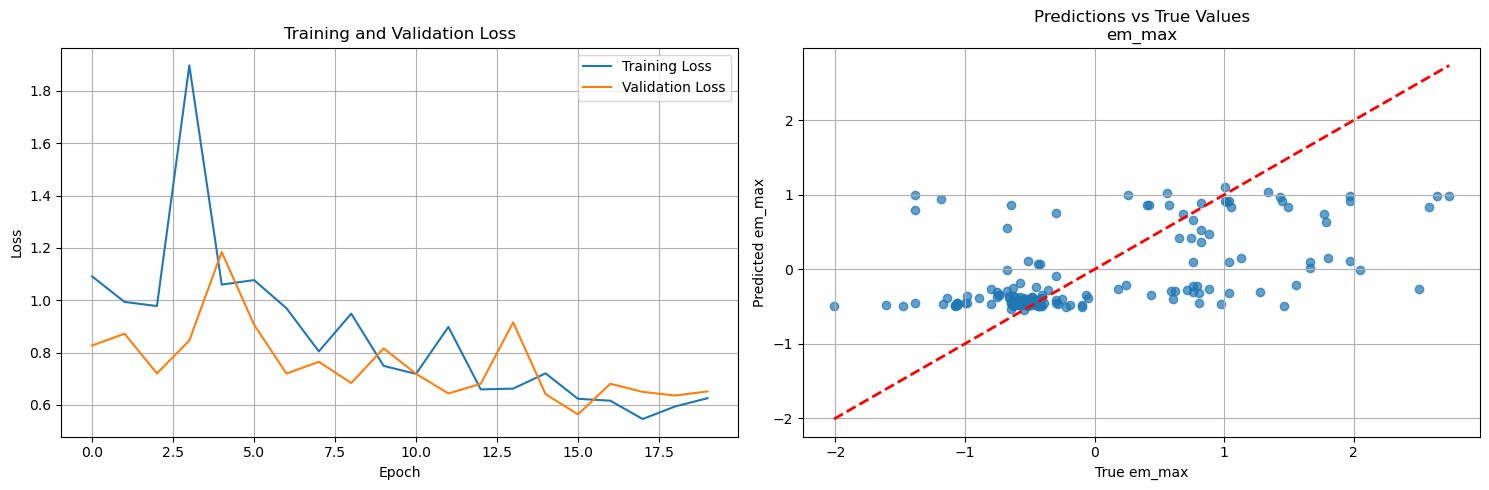


Model saved as 'lstm_model_em_max_embeddings.pth'


In [ ]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 238
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

sample_batch = next(iter(train_loader))[0]
embedding_dim = sample_batch.shape[-1]

# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = ProteinLSTM(
        input_dim=20,  # One-hot encoded amino acids
        hidden_dim=256,
        num_layers=2,
        output_dim=1,
        dropout=0.3,
        bidirectional=True
    )

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'lstm_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_onehot.pth'")


<h3>Работа с EmbeddingLSTM</h3>

In [ ]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 238
BATCH_SIZE = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.001

sample_batch = next(iter(train_loader))[0]
embedding_dim = sample_batch.shape[-1]

# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = EmbeddingLSTM(
    embedding_dim=embedding_dim,
    hidden_size=128,
    num_layers=2,
    dropout_rate=0.1
).to(device)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'lstm_model_{TARGET_PROPERTY}_embeddings.pth')
print(f"\nModel saved as 'lstm_model_{TARGET_PROPERTY}_embeddings.pth'")


Training on cuda
Number of parameters: 1,553,153


Epoch 10/200: 100%|██████████| 17/17 [00:01<00:00, 13.21it/s]


Epoch 10/200
Train Loss: 0.9622, Val Loss: 1.2318
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/200: 100%|██████████| 17/17 [00:01<00:00, 13.33it/s]


Epoch 20/200
Train Loss: 0.9559, Val Loss: 1.0025
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/200: 100%|██████████| 17/17 [00:01<00:00, 13.00it/s]


Epoch 30/200
Train Loss: 1.1004, Val Loss: 0.8401
Learning Rate: 0.001000
--------------------------------------------------


Epoch 40/200: 100%|██████████| 17/17 [00:01<00:00, 13.60it/s]


Epoch 40/200
Train Loss: 0.9507, Val Loss: 2.2785
Learning Rate: 0.001000
--------------------------------------------------


Epoch 50/200: 100%|██████████| 17/17 [00:01<00:00, 12.89it/s]


Epoch 50/200
Train Loss: 1.0033, Val Loss: 1.2278
Learning Rate: 0.001000
--------------------------------------------------


Epoch 53/200:  29%|██▉       | 5/17 [00:00<00:01,  9.34it/s]


KeyboardInterrupt: 

### Обучение ProteinCNN

Training on cuda
Number of parameters: 487,041


Epoch 10/1000: 100%|██████████| 17/17 [00:00<00:00, 56.97it/s]


Epoch 10/1000
Train Loss: 0.3471, Val Loss: 1.5785
Learning Rate: 0.001000
--------------------------------------------------


Epoch 20/1000: 100%|██████████| 17/17 [00:00<00:00, 52.79it/s]


Epoch 20/1000
Train Loss: 0.2507, Val Loss: 33.2978
Learning Rate: 0.001000
--------------------------------------------------


Epoch 30/1000: 100%|██████████| 17/17 [00:00<00:00, 55.39it/s]


Epoch 30/1000
Train Loss: 0.2717, Val Loss: 0.2340
Learning Rate: 0.001000
--------------------------------------------------


Epoch 40/1000: 100%|██████████| 17/17 [00:00<00:00, 56.33it/s]


Epoch 40/1000
Train Loss: 0.1734, Val Loss: 0.3239
Learning Rate: 0.001000
--------------------------------------------------


Epoch 50/1000: 100%|██████████| 17/17 [00:00<00:00, 46.35it/s]


Epoch 50/1000
Train Loss: 0.1500, Val Loss: 0.2874
Learning Rate: 0.001000
--------------------------------------------------


Epoch 60/1000: 100%|██████████| 17/17 [00:00<00:00, 49.21it/s]


Epoch 60/1000
Train Loss: 0.1889, Val Loss: 0.2309
Learning Rate: 0.001000
--------------------------------------------------


Epoch 70/1000: 100%|██████████| 17/17 [00:00<00:00, 49.99it/s]


Epoch 70/1000
Train Loss: 0.1591, Val Loss: 1.6320
Learning Rate: 0.001000
--------------------------------------------------


Epoch 80/1000: 100%|██████████| 17/17 [00:00<00:00, 50.15it/s]


Epoch 80/1000
Train Loss: 0.1587, Val Loss: 0.2813
Learning Rate: 0.001000
--------------------------------------------------


Epoch 90/1000: 100%|██████████| 17/17 [00:00<00:00, 53.25it/s]


Epoch 90/1000
Train Loss: 0.1049, Val Loss: 0.2620
Learning Rate: 0.001000
--------------------------------------------------


Epoch 100/1000: 100%|██████████| 17/17 [00:00<00:00, 47.42it/s]


Epoch 100/1000
Train Loss: 0.0975, Val Loss: 0.2754
Learning Rate: 0.001000
--------------------------------------------------


Epoch 110/1000: 100%|██████████| 17/17 [00:00<00:00, 47.30it/s]


Epoch 110/1000
Train Loss: 0.0845, Val Loss: 0.6213
Learning Rate: 0.001000
--------------------------------------------------


Epoch 120/1000: 100%|██████████| 17/17 [00:00<00:00, 56.87it/s]


Epoch 120/1000
Train Loss: 0.0872, Val Loss: 0.3221
Learning Rate: 0.001000
--------------------------------------------------


Epoch 130/1000: 100%|██████████| 17/17 [00:00<00:00, 56.36it/s]


Epoch 130/1000
Train Loss: 0.0907, Val Loss: 0.3089
Learning Rate: 0.001000
--------------------------------------------------


Epoch 140/1000: 100%|██████████| 17/17 [00:00<00:00, 55.49it/s]


Epoch 140/1000
Train Loss: 0.0879, Val Loss: 0.2687
Learning Rate: 0.001000
--------------------------------------------------


Epoch 150/1000: 100%|██████████| 17/17 [00:00<00:00, 56.20it/s]


Epoch 150/1000
Train Loss: 0.1874, Val Loss: 0.1928
Learning Rate: 0.001000
--------------------------------------------------


Epoch 160/1000: 100%|██████████| 17/17 [00:00<00:00, 57.08it/s]


Epoch 160/1000
Train Loss: 0.0919, Val Loss: 0.2327
Learning Rate: 0.001000
--------------------------------------------------


Epoch 170/1000: 100%|██████████| 17/17 [00:00<00:00, 55.15it/s]


Epoch 170/1000
Train Loss: 0.0956, Val Loss: 0.2716
Learning Rate: 0.001000
--------------------------------------------------


Epoch 180/1000: 100%|██████████| 17/17 [00:00<00:00, 58.30it/s]


Epoch 180/1000
Train Loss: 0.1228, Val Loss: 0.2660
Learning Rate: 0.001000
--------------------------------------------------


Epoch 190/1000: 100%|██████████| 17/17 [00:00<00:00, 57.76it/s]


Epoch 190/1000
Train Loss: 0.0793, Val Loss: 0.2336
Learning Rate: 0.001000
--------------------------------------------------


Epoch 200/1000: 100%|██████████| 17/17 [00:00<00:00, 56.71it/s]


Epoch 200/1000
Train Loss: 0.1014, Val Loss: 0.1852
Learning Rate: 0.001000
--------------------------------------------------


Epoch 210/1000: 100%|██████████| 17/17 [00:00<00:00, 57.22it/s]


Epoch 210/1000
Train Loss: 0.0633, Val Loss: 0.2763
Learning Rate: 0.001000
--------------------------------------------------


Epoch 220/1000: 100%|██████████| 17/17 [00:00<00:00, 54.56it/s]


Epoch 220/1000
Train Loss: 0.0545, Val Loss: 0.1669
Learning Rate: 0.001000
--------------------------------------------------


Epoch 230/1000: 100%|██████████| 17/17 [00:00<00:00, 53.56it/s]


Epoch 230/1000
Train Loss: 0.2319, Val Loss: 0.2627
Learning Rate: 0.001000
--------------------------------------------------


Epoch 240/1000: 100%|██████████| 17/17 [00:00<00:00, 50.18it/s]


Epoch 240/1000
Train Loss: 0.0762, Val Loss: 0.2442
Learning Rate: 0.001000
--------------------------------------------------


Epoch 250/1000: 100%|██████████| 17/17 [00:00<00:00, 52.80it/s]


Epoch 250/1000
Train Loss: 0.0745, Val Loss: 0.1874
Learning Rate: 0.001000
--------------------------------------------------


Epoch 260/1000: 100%|██████████| 17/17 [00:00<00:00, 47.47it/s]


Epoch 260/1000
Train Loss: 0.0579, Val Loss: 0.2412
Learning Rate: 0.001000
--------------------------------------------------


Epoch 270/1000: 100%|██████████| 17/17 [00:00<00:00, 49.27it/s]


Epoch 270/1000
Train Loss: 0.0584, Val Loss: 0.2186
Learning Rate: 0.001000
--------------------------------------------------


Epoch 280/1000: 100%|██████████| 17/17 [00:00<00:00, 54.59it/s]


Epoch 280/1000
Train Loss: 0.0598, Val Loss: 0.1817
Learning Rate: 0.001000
--------------------------------------------------


Epoch 290/1000: 100%|██████████| 17/17 [00:00<00:00, 57.06it/s]


Epoch 290/1000
Train Loss: 0.0638, Val Loss: 0.1878
Learning Rate: 0.001000
--------------------------------------------------


Epoch 300/1000: 100%|██████████| 17/17 [00:00<00:00, 57.72it/s]


Epoch 300/1000
Train Loss: 0.0782, Val Loss: 0.2566
Learning Rate: 0.001000
--------------------------------------------------


Epoch 310/1000: 100%|██████████| 17/17 [00:00<00:00, 55.19it/s]


Epoch 310/1000
Train Loss: 0.0618, Val Loss: 0.2620
Learning Rate: 0.001000
--------------------------------------------------


Epoch 320/1000: 100%|██████████| 17/17 [00:00<00:00, 48.45it/s]


Epoch 320/1000
Train Loss: 0.0542, Val Loss: 0.2956
Learning Rate: 0.001000
--------------------------------------------------


Epoch 330/1000: 100%|██████████| 17/17 [00:00<00:00, 56.50it/s]


Epoch 330/1000
Train Loss: 0.0515, Val Loss: 0.2448
Learning Rate: 0.001000
--------------------------------------------------


Epoch 340/1000: 100%|██████████| 17/17 [00:00<00:00, 50.77it/s]


Epoch 340/1000
Train Loss: 0.0767, Val Loss: 0.2076
Learning Rate: 0.001000
--------------------------------------------------


Epoch 350/1000: 100%|██████████| 17/17 [00:00<00:00, 55.94it/s]


Epoch 350/1000
Train Loss: 0.0693, Val Loss: 0.2251
Learning Rate: 0.001000
--------------------------------------------------


Epoch 360/1000: 100%|██████████| 17/17 [00:00<00:00, 52.95it/s]


Epoch 360/1000
Train Loss: 0.0679, Val Loss: 1.8037
Learning Rate: 0.001000
--------------------------------------------------


Epoch 370/1000: 100%|██████████| 17/17 [00:00<00:00, 56.95it/s]


Epoch 370/1000
Train Loss: 0.0597, Val Loss: 0.2755
Learning Rate: 0.001000
--------------------------------------------------


Epoch 380/1000: 100%|██████████| 17/17 [00:00<00:00, 58.42it/s]


Epoch 380/1000
Train Loss: 0.0598, Val Loss: 0.2486
Learning Rate: 0.001000
--------------------------------------------------


Epoch 390/1000: 100%|██████████| 17/17 [00:00<00:00, 57.74it/s]


Epoch 390/1000
Train Loss: 0.1068, Val Loss: 0.2027
Learning Rate: 0.001000
--------------------------------------------------


Epoch 400/1000: 100%|██████████| 17/17 [00:00<00:00, 57.27it/s]


Epoch 400/1000
Train Loss: 0.0543, Val Loss: 0.2564
Learning Rate: 0.001000
--------------------------------------------------


Epoch 410/1000: 100%|██████████| 17/17 [00:00<00:00, 57.08it/s]


Epoch 410/1000
Train Loss: 0.0602, Val Loss: 0.1910
Learning Rate: 0.001000
--------------------------------------------------


Epoch 420/1000: 100%|██████████| 17/17 [00:00<00:00, 55.37it/s]


Epoch 420/1000
Train Loss: 0.0483, Val Loss: 0.2194
Learning Rate: 0.001000
--------------------------------------------------


Epoch 430/1000: 100%|██████████| 17/17 [00:00<00:00, 57.33it/s]


Epoch 430/1000
Train Loss: 0.0679, Val Loss: 0.2362
Learning Rate: 0.001000
--------------------------------------------------


Epoch 440/1000: 100%|██████████| 17/17 [00:00<00:00, 55.09it/s]


Epoch 440/1000
Train Loss: 0.4077, Val Loss: 0.2123
Learning Rate: 0.001000
--------------------------------------------------


Epoch 450/1000: 100%|██████████| 17/17 [00:00<00:00, 57.10it/s]


Epoch 450/1000
Train Loss: 0.0712, Val Loss: 0.2678
Learning Rate: 0.001000
--------------------------------------------------


Epoch 460/1000: 100%|██████████| 17/17 [00:00<00:00, 57.76it/s]


Epoch 460/1000
Train Loss: 0.0545, Val Loss: 0.1787
Learning Rate: 0.001000
--------------------------------------------------


Epoch 470/1000: 100%|██████████| 17/17 [00:00<00:00, 57.73it/s]


Epoch 470/1000
Train Loss: 0.0521, Val Loss: 0.2109
Learning Rate: 0.001000
--------------------------------------------------


Epoch 480/1000: 100%|██████████| 17/17 [00:00<00:00, 57.26it/s]


Epoch 480/1000
Train Loss: 0.0418, Val Loss: 0.2763
Learning Rate: 0.001000
--------------------------------------------------


Epoch 490/1000: 100%|██████████| 17/17 [00:00<00:00, 57.85it/s]


Epoch 490/1000
Train Loss: 0.0802, Val Loss: 0.2834
Learning Rate: 0.001000
--------------------------------------------------


Epoch 500/1000: 100%|██████████| 17/17 [00:00<00:00, 55.97it/s]


Epoch 500/1000
Train Loss: 0.0493, Val Loss: 0.2509
Learning Rate: 0.001000
--------------------------------------------------


Epoch 510/1000: 100%|██████████| 17/17 [00:00<00:00, 56.84it/s]


Epoch 510/1000
Train Loss: 0.0528, Val Loss: 0.2130
Learning Rate: 0.001000
--------------------------------------------------


Epoch 520/1000: 100%|██████████| 17/17 [00:00<00:00, 55.82it/s]


Epoch 520/1000
Train Loss: 0.0820, Val Loss: 0.2050
Learning Rate: 0.001000
--------------------------------------------------


Epoch 530/1000: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s]


Epoch 530/1000
Train Loss: 0.0575, Val Loss: 0.2354
Learning Rate: 0.001000
--------------------------------------------------


Epoch 540/1000: 100%|██████████| 17/17 [00:00<00:00, 49.77it/s]


Epoch 540/1000
Train Loss: 0.0784, Val Loss: 0.1999
Learning Rate: 0.001000
--------------------------------------------------


Epoch 550/1000: 100%|██████████| 17/17 [00:00<00:00, 55.84it/s]


Epoch 550/1000
Train Loss: 0.0676, Val Loss: 0.2534
Learning Rate: 0.001000
--------------------------------------------------


Epoch 560/1000: 100%|██████████| 17/17 [00:00<00:00, 50.48it/s]


Epoch 560/1000
Train Loss: 0.0605, Val Loss: 0.1795
Learning Rate: 0.001000
--------------------------------------------------


Epoch 570/1000: 100%|██████████| 17/17 [00:00<00:00, 48.88it/s]


Epoch 570/1000
Train Loss: 0.0461, Val Loss: 0.2306
Learning Rate: 0.001000
--------------------------------------------------


Epoch 580/1000: 100%|██████████| 17/17 [00:00<00:00, 49.42it/s]


Epoch 580/1000
Train Loss: 0.0480, Val Loss: 0.1784
Learning Rate: 0.001000
--------------------------------------------------


Epoch 590/1000: 100%|██████████| 17/17 [00:00<00:00, 49.55it/s]


Epoch 590/1000
Train Loss: 0.0474, Val Loss: 0.2011
Learning Rate: 0.001000
--------------------------------------------------


Epoch 600/1000: 100%|██████████| 17/17 [00:00<00:00, 48.65it/s]


Epoch 600/1000
Train Loss: 0.0487, Val Loss: 0.2235
Learning Rate: 0.001000
--------------------------------------------------


Epoch 610/1000: 100%|██████████| 17/17 [00:00<00:00, 53.84it/s]


Epoch 610/1000
Train Loss: 0.0407, Val Loss: 0.2212
Learning Rate: 0.001000
--------------------------------------------------


Epoch 620/1000: 100%|██████████| 17/17 [00:00<00:00, 53.39it/s]


Epoch 620/1000
Train Loss: 0.0553, Val Loss: 0.3473
Learning Rate: 0.001000
--------------------------------------------------


Epoch 630/1000: 100%|██████████| 17/17 [00:00<00:00, 58.44it/s]


Epoch 630/1000
Train Loss: 0.0469, Val Loss: 0.1966
Learning Rate: 0.001000
--------------------------------------------------


Epoch 640/1000: 100%|██████████| 17/17 [00:00<00:00, 53.74it/s]


Epoch 640/1000
Train Loss: 0.0519, Val Loss: 0.2197
Learning Rate: 0.001000
--------------------------------------------------


Epoch 650/1000: 100%|██████████| 17/17 [00:00<00:00, 55.35it/s]


Epoch 650/1000
Train Loss: 0.0727, Val Loss: 0.1975
Learning Rate: 0.001000
--------------------------------------------------


Epoch 660/1000: 100%|██████████| 17/17 [00:00<00:00, 55.02it/s]


Epoch 660/1000
Train Loss: 0.0474, Val Loss: 0.2235
Learning Rate: 0.001000
--------------------------------------------------


Epoch 670/1000: 100%|██████████| 17/17 [00:00<00:00, 53.35it/s]


Epoch 670/1000
Train Loss: 0.0418, Val Loss: 0.2217
Learning Rate: 0.001000
--------------------------------------------------


Epoch 680/1000: 100%|██████████| 17/17 [00:00<00:00, 53.68it/s]


Epoch 680/1000
Train Loss: 0.0496, Val Loss: 0.2455
Learning Rate: 0.001000
--------------------------------------------------


Epoch 690/1000: 100%|██████████| 17/17 [00:00<00:00, 54.53it/s]


Epoch 690/1000
Train Loss: 0.0712, Val Loss: 0.1923
Learning Rate: 0.001000
--------------------------------------------------


Epoch 700/1000: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s]


Epoch 700/1000
Train Loss: 0.0655, Val Loss: 0.2585
Learning Rate: 0.001000
--------------------------------------------------


Epoch 710/1000: 100%|██████████| 17/17 [00:00<00:00, 52.76it/s]


Epoch 710/1000
Train Loss: 0.1901, Val Loss: 0.3694
Learning Rate: 0.001000
--------------------------------------------------


Epoch 720/1000: 100%|██████████| 17/17 [00:00<00:00, 47.54it/s]


Epoch 720/1000
Train Loss: 0.0497, Val Loss: 0.2133
Learning Rate: 0.001000
--------------------------------------------------


Epoch 730/1000: 100%|██████████| 17/17 [00:00<00:00, 46.87it/s]


Epoch 730/1000
Train Loss: 0.0977, Val Loss: 0.1904
Learning Rate: 0.001000
--------------------------------------------------


Epoch 740/1000: 100%|██████████| 17/17 [00:00<00:00, 47.70it/s]


Epoch 740/1000
Train Loss: 0.0502, Val Loss: 0.2250
Learning Rate: 0.001000
--------------------------------------------------


Epoch 750/1000: 100%|██████████| 17/17 [00:00<00:00, 42.37it/s]


Epoch 750/1000
Train Loss: 0.0442, Val Loss: 0.2002
Learning Rate: 0.001000
--------------------------------------------------


Epoch 760/1000: 100%|██████████| 17/17 [00:00<00:00, 51.25it/s]


Epoch 760/1000
Train Loss: 0.0644, Val Loss: 0.3549
Learning Rate: 0.001000
--------------------------------------------------


Epoch 770/1000: 100%|██████████| 17/17 [00:00<00:00, 47.41it/s]


Epoch 770/1000
Train Loss: 0.0432, Val Loss: 0.1916
Learning Rate: 0.001000
--------------------------------------------------


Epoch 780/1000: 100%|██████████| 17/17 [00:00<00:00, 47.21it/s]


Epoch 780/1000
Train Loss: 0.0465, Val Loss: 0.2119
Learning Rate: 0.001000
--------------------------------------------------


Epoch 790/1000: 100%|██████████| 17/17 [00:00<00:00, 50.48it/s]


Epoch 790/1000
Train Loss: 0.0499, Val Loss: 0.2187
Learning Rate: 0.001000
--------------------------------------------------


Epoch 800/1000: 100%|██████████| 17/17 [00:00<00:00, 48.12it/s]


Epoch 800/1000
Train Loss: 0.0532, Val Loss: 0.2141
Learning Rate: 0.001000
--------------------------------------------------


Epoch 810/1000: 100%|██████████| 17/17 [00:00<00:00, 52.70it/s]


Epoch 810/1000
Train Loss: 0.0346, Val Loss: 0.1964
Learning Rate: 0.001000
--------------------------------------------------


Epoch 820/1000: 100%|██████████| 17/17 [00:00<00:00, 58.04it/s]


Epoch 820/1000
Train Loss: 0.0455, Val Loss: 0.2632
Learning Rate: 0.001000
--------------------------------------------------


Epoch 830/1000: 100%|██████████| 17/17 [00:00<00:00, 55.33it/s]


Epoch 830/1000
Train Loss: 0.0401, Val Loss: 0.2347
Learning Rate: 0.001000
--------------------------------------------------


Epoch 840/1000: 100%|██████████| 17/17 [00:00<00:00, 57.69it/s]


Epoch 840/1000
Train Loss: 0.0500, Val Loss: 0.1809
Learning Rate: 0.001000
--------------------------------------------------


Epoch 850/1000: 100%|██████████| 17/17 [00:00<00:00, 58.01it/s]


Epoch 850/1000
Train Loss: 0.0631, Val Loss: 0.1772
Learning Rate: 0.001000
--------------------------------------------------


Epoch 860/1000: 100%|██████████| 17/17 [00:00<00:00, 54.60it/s]


Epoch 860/1000
Train Loss: 0.0426, Val Loss: 0.1904
Learning Rate: 0.001000
--------------------------------------------------


Epoch 870/1000: 100%|██████████| 17/17 [00:00<00:00, 53.87it/s]


Epoch 870/1000
Train Loss: 0.0473, Val Loss: 0.2080
Learning Rate: 0.001000
--------------------------------------------------


Epoch 880/1000: 100%|██████████| 17/17 [00:00<00:00, 57.85it/s]


Epoch 880/1000
Train Loss: 0.0370, Val Loss: 0.2477
Learning Rate: 0.001000
--------------------------------------------------


Epoch 890/1000: 100%|██████████| 17/17 [00:00<00:00, 57.81it/s]


Epoch 890/1000
Train Loss: 0.0562, Val Loss: 0.2197
Learning Rate: 0.001000
--------------------------------------------------


Epoch 900/1000: 100%|██████████| 17/17 [00:00<00:00, 56.81it/s]


Epoch 900/1000
Train Loss: 0.0459, Val Loss: 0.1610
Learning Rate: 0.001000
--------------------------------------------------


Epoch 910/1000: 100%|██████████| 17/17 [00:00<00:00, 48.04it/s]


Epoch 910/1000
Train Loss: 0.0525, Val Loss: 0.2111
Learning Rate: 0.001000
--------------------------------------------------


Epoch 920/1000: 100%|██████████| 17/17 [00:00<00:00, 53.74it/s]


Epoch 920/1000
Train Loss: 0.0432, Val Loss: 0.2438
Learning Rate: 0.001000
--------------------------------------------------


Epoch 930/1000: 100%|██████████| 17/17 [00:00<00:00, 53.58it/s]


Epoch 930/1000
Train Loss: 0.0582, Val Loss: 0.1831
Learning Rate: 0.001000
--------------------------------------------------


Epoch 940/1000: 100%|██████████| 17/17 [00:00<00:00, 52.82it/s]


Epoch 940/1000
Train Loss: 0.0566, Val Loss: 0.2148
Learning Rate: 0.001000
--------------------------------------------------


Epoch 950/1000: 100%|██████████| 17/17 [00:00<00:00, 52.92it/s]


Epoch 950/1000
Train Loss: 0.0422, Val Loss: 0.2019
Learning Rate: 0.001000
--------------------------------------------------


Epoch 960/1000: 100%|██████████| 17/17 [00:00<00:00, 52.13it/s]


Epoch 960/1000
Train Loss: 0.0481, Val Loss: 0.2214
Learning Rate: 0.001000
--------------------------------------------------


Epoch 970/1000: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s]


Epoch 970/1000
Train Loss: 0.0404, Val Loss: 0.2456
Learning Rate: 0.001000
--------------------------------------------------


Epoch 980/1000: 100%|██████████| 17/17 [00:00<00:00, 52.20it/s]


Epoch 980/1000
Train Loss: 0.0419, Val Loss: 0.2235
Learning Rate: 0.001000
--------------------------------------------------


Epoch 990/1000: 100%|██████████| 17/17 [00:00<00:00, 53.39it/s]


Epoch 990/1000
Train Loss: 0.0368, Val Loss: 0.2464
Learning Rate: 0.001000
--------------------------------------------------


Epoch 1000/1000: 100%|██████████| 17/17 [00:00<00:00, 52.57it/s]


Epoch 1000/1000
Train Loss: 0.0444, Val Loss: 0.2648
Learning Rate: 0.001000
--------------------------------------------------

Test MSE: 0.2474
Test MAE: 0.3352
Test R²:  0.7236


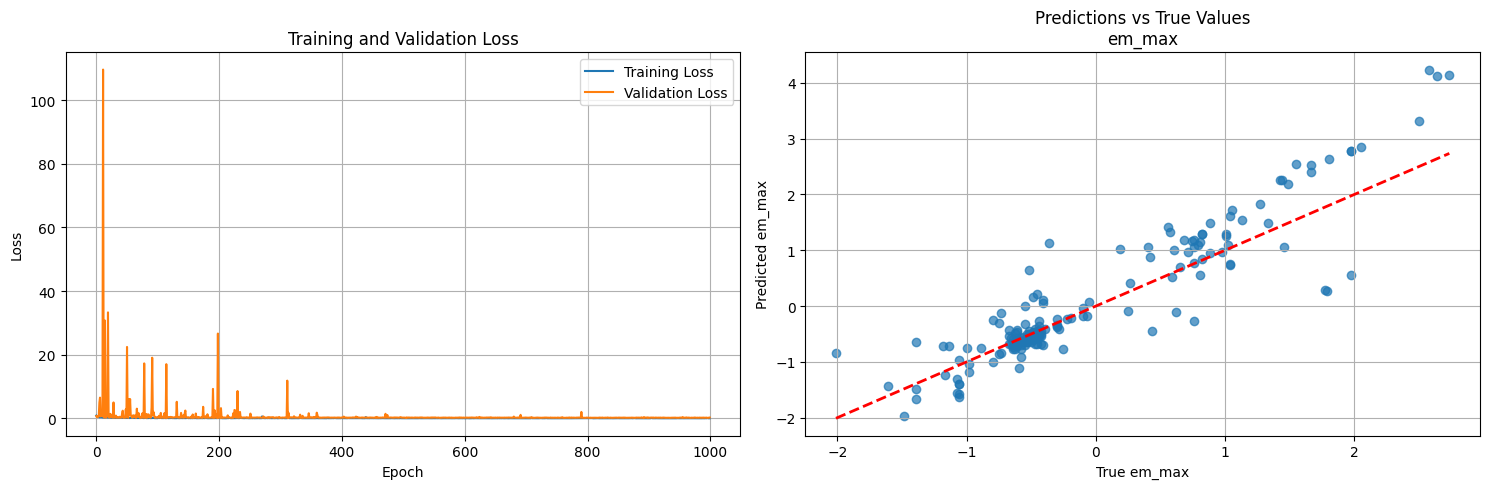


Model saved as 'cnn_model_em_max_onehot.pth'


In [20]:
"""Main training pipeline."""
TARGET_PROPERTY = 'em_max'  # Change this to predict different properties

# Available properties from your dataset:
# brightness, ex_max, em_max, ext_coeff, lifetime, maturation, pka, stokes_shift, qy, agg, switch_type

# Hyperparameters
MAX_LENGTH = 238
BATCH_SIZE = 64
NUM_EPOCHS = 1000
LEARNING_RATE = 0.001

sample_batch = next(iter(train_loader))[0]
embedding_dim = sample_batch.shape[-1]

# Instantiate the new model
# выбор между EmbeddingLSTM и ProteinLSTM
model = ProteinCNN(
    num_amino_acids=20, 
    num_filters=128,
    dropout_rate=0.5
)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
)

# Evaluate
predictions1, true_values, mse, mae, r2 = evaluate_model(
    trained_model, test_loader, dataset_test, TARGET_PROPERTY
)

# Plot
plot_results(train_losses, val_losses, predictions1, true_values, TARGET_PROPERTY)

# Save model
torch.save(trained_model.state_dict(), f'cnn_model_{TARGET_PROPERTY}_onehot.pth')
print(f"\nModel saved as 'cnn_model_{TARGET_PROPERTY}_onehot.pth'")

In [19]:
trained_model.eval()

predictions = []
true_values = []

with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        batch_predictions = model(sequences).squeeze()

        predictions.extend(batch_predictions.cpu().numpy())
        true_values.extend(targets.cpu().numpy())

    # Convert back to original scale
predictions = np.array(predictions)
true_values = np.array(true_values)

zv = get_regression_metrics(
    dataset.rescale_targets(predictions, TARGET_PROPERTY),
    dataset.rescale_targets(true_values, TARGET_PROPERTY)
)
print(f'\t RMSE: {zv["rmse"]}')
print(f'\t MAE: {zv["mae"]}')
print(f'\t R2: {zv["r2"]}')
print(f'\t MAE (med.): {zv["mae_median"]}')

	 RMSE: 31.98543930053711
	 MAE: 24.92881965637207
	 R2: 0.7231724858283997
	 MAE (med.): 19.35626220703125
